# Fitting the pulse by pulse with a double exponential

##### Steps that are taken care of in this code
1. Reads in a list of files corresponding to a period and run.
2. Make a natural logarithm of the waveform.
3. Make linear fits corresponding to the fast and the slow regions.
4. Make a double exponential fit.
5. Extract the timestamp and plot against the energy.

Use the legend-sw kernel<br>

Jita (26 Sep 2023)

In [1]:
def energy_selection(hit_df, energy_low, energy_high):
    selection = (hit_df['cuspEmax_ctc_cal'] >= energy_low) & (hit_df['cuspEmax_ctc_cal'] <= energy_high)
    return(selection)

In [2]:
def pileup_flagger(data_raw, evt):
    # Careful with data_raw.values is unsigned. Convert to int before using the np.diff.
    wf_diff = np.diff(data_raw.values[evt].astype(int))
    pileup = np.any(wf_diff[3100:] > 75)
    return(pileup)

In [3]:
def linear(x, a, b):                              
    return a * x + b      

In [4]:
def amp_est(wf):
    wf_max = np.max(wf)
    wf_min = np.min(wf)
    amp = wf_max - wf_min
    return (amp)

In [5]:
def bsln_est(wf):
    bsln = np.average(wf[0:2000])
    return (bsln)

In [6]:
def doubleExp(x, bsln, amp1, amp_sum, tau1, tau2):
    return bsln + amp1 * np.exp(-x/tau1) + (amp_sum - amp1) * np.exp(-x/tau2)

In [7]:
# Import packages
import pygama.lgdo.lh5_store as lh5 
from lgdo import LH5Store
from legendmeta import LegendMetadata

import glob
from datetime import datetime, timezone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
from scipy import optimize

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import ticker

In [8]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
#formatter.set_powerlimits((-1,1))

In [9]:
# Selecting the data
data_type = "cal"
data_period = "p03"
data_run = "r000"
expt = "l200"

# Setting up the paths
raw_file = sorted(glob.glob(f"/global/cfs/cdirs/m2676/data/lngs/l200/public/prodenv/prod-orig/archive/raw-v01.00/generated/tier/raw/{data_type}/{data_period}/{data_run}/{expt}-{data_period}-{data_run}-{data_type}-*-tier_raw.lh5"))
dsp_file = sorted(glob.glob(f"/global/cfs/cdirs/m2676/data/lngs/l200/public/prodenv/prod-blind/ref/v01.06/generated/tier/dsp/{data_type}/{data_period}/{data_run}/{expt}-{data_period}-{data_run}-{data_type}-*-tier_dsp.lh5"))
hit_file = sorted(glob.glob(f"/global/cfs/cdirs/m2676/data/lngs/l200/public/prodenv/prod-blind/ref/v01.06/generated/tier/hit/{data_type}/{data_period}/{data_run}/{expt}-{data_period}-{data_run}-{data_type}-*-tier_hit.lh5"))

86
143
147
510
514
648
674
723
731
774
1089
1199
1312
1430
1432
1467
1622
1623
1687
1728
1799
1881
1914
1946
1990
1997
2026
2036
2121
2327
2381
2395
2419
2421
2462
2550
2638
2688
2699
2746
3022
3088
3209
3211
3257
3259
3330
3366
3394
3421
3453
3480
3512
3526
3627
3631
3639
3687
3741
3749
3856
4033
4202
4256
4323
4414
4676
4714
4731
4760
4970
5096
5130
5169
5248
5376
5479
5517
5543
5582
5607
5717
5804
5867
5879
5991
6116
6250
6314
6325
6468
6508
6540
6626
6672
6804
6840
6849
6894
6939
7012
7018
7096
7133
7167
7195
7338
7364
7498
7511


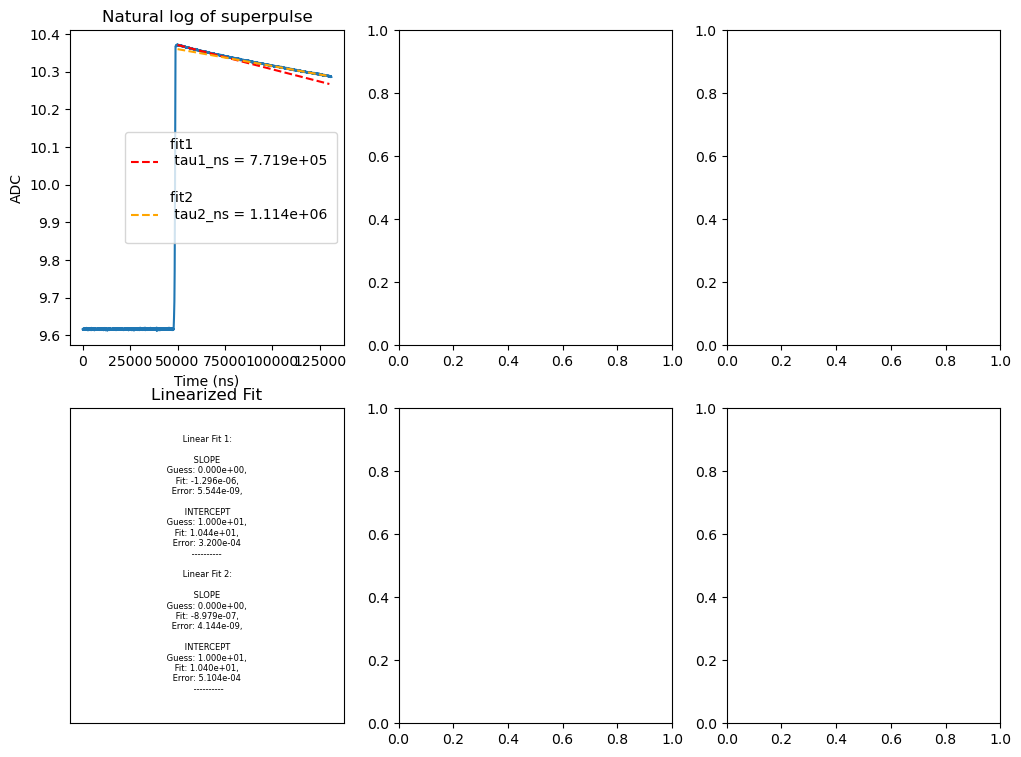

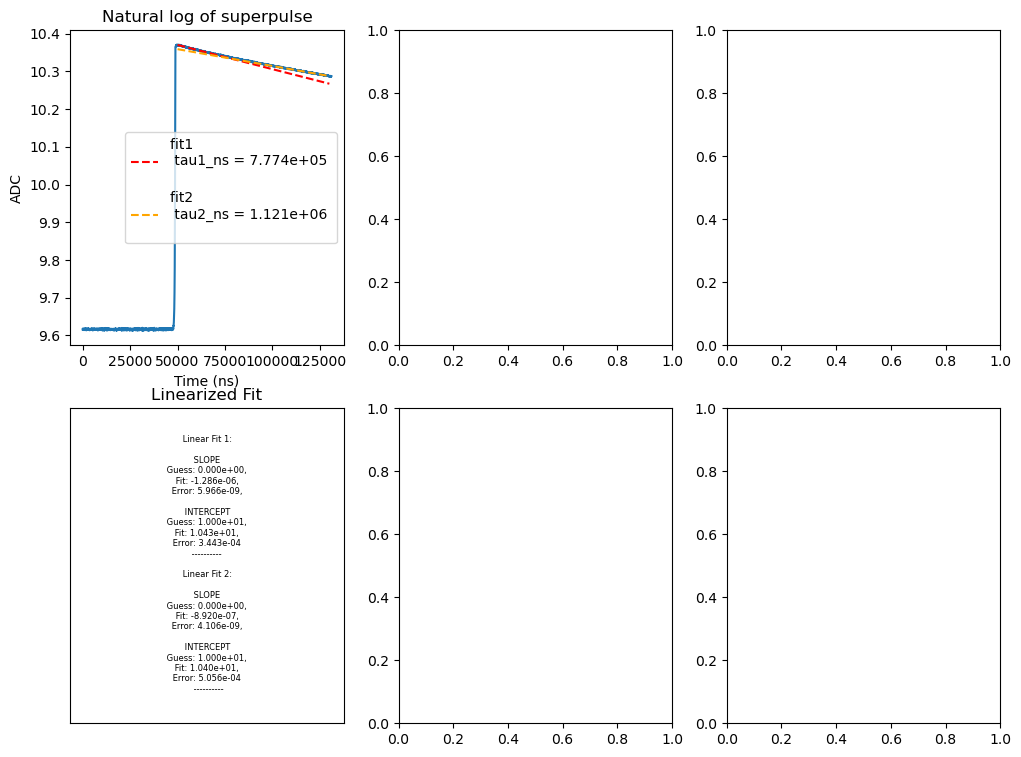

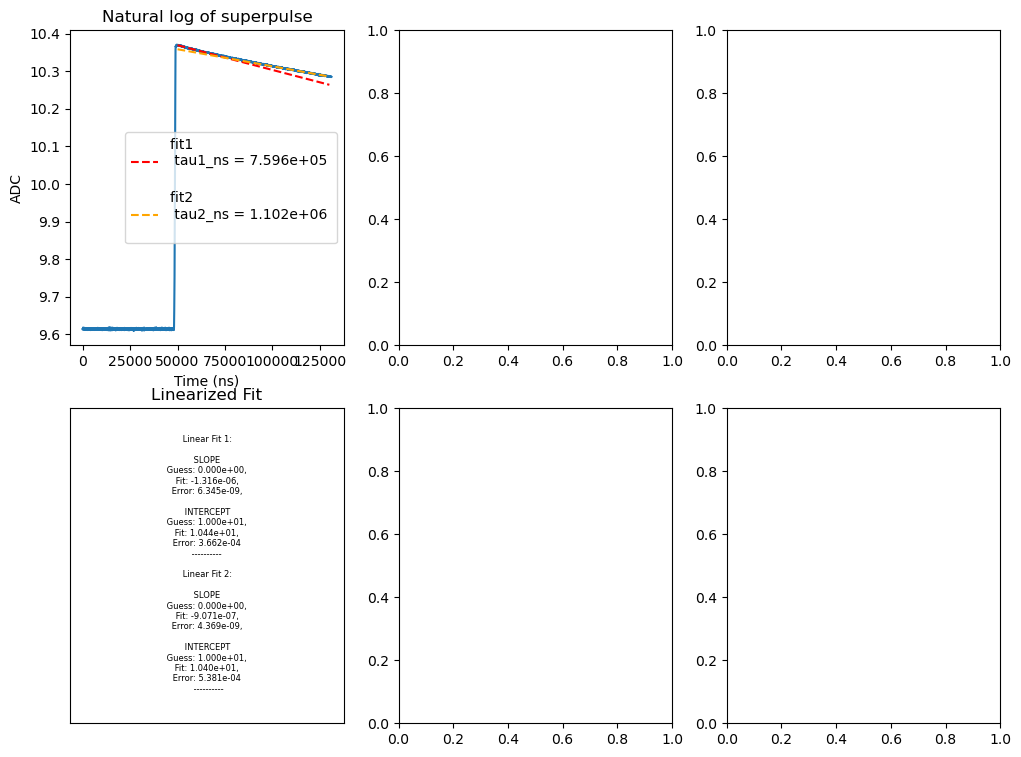

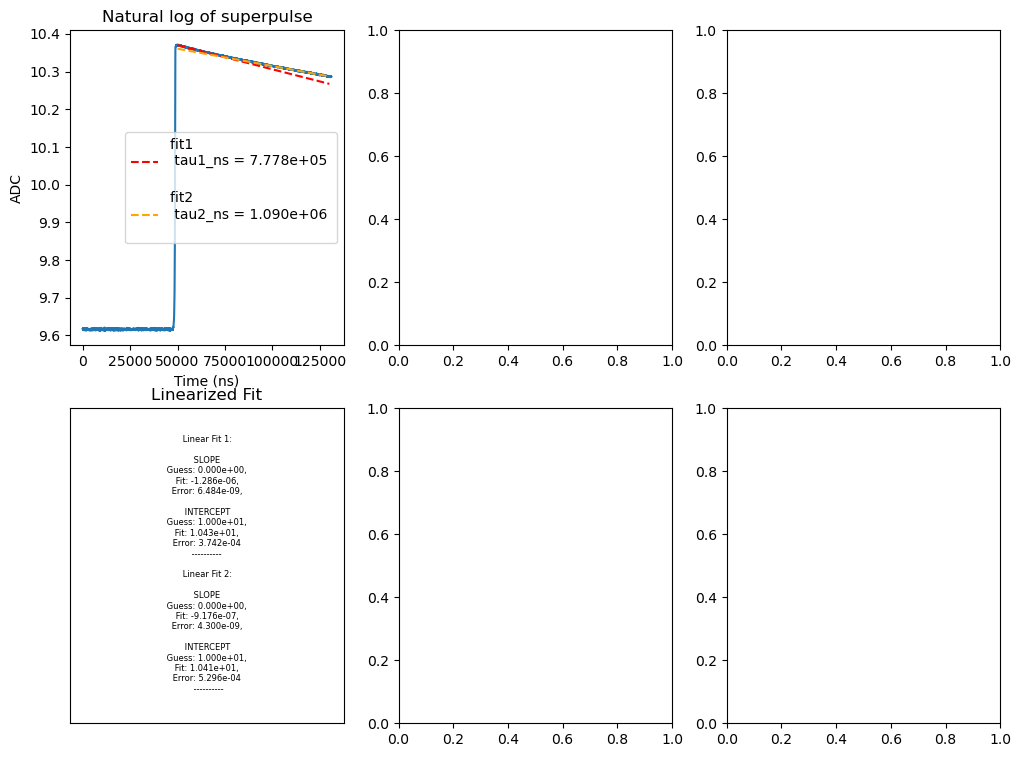

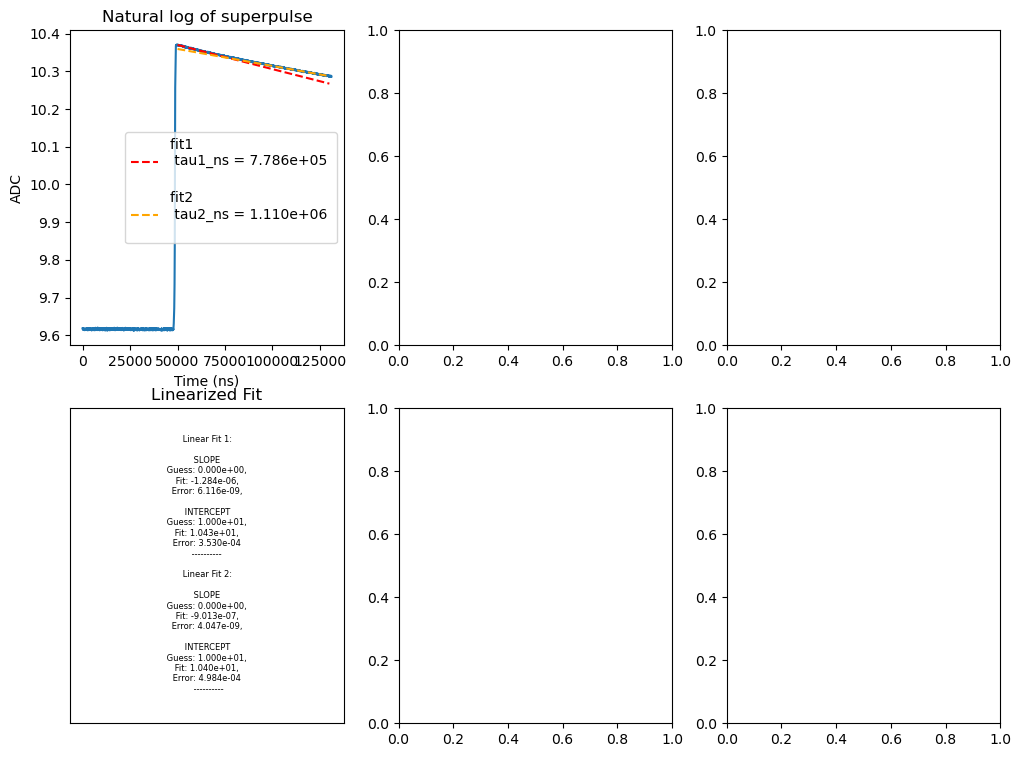

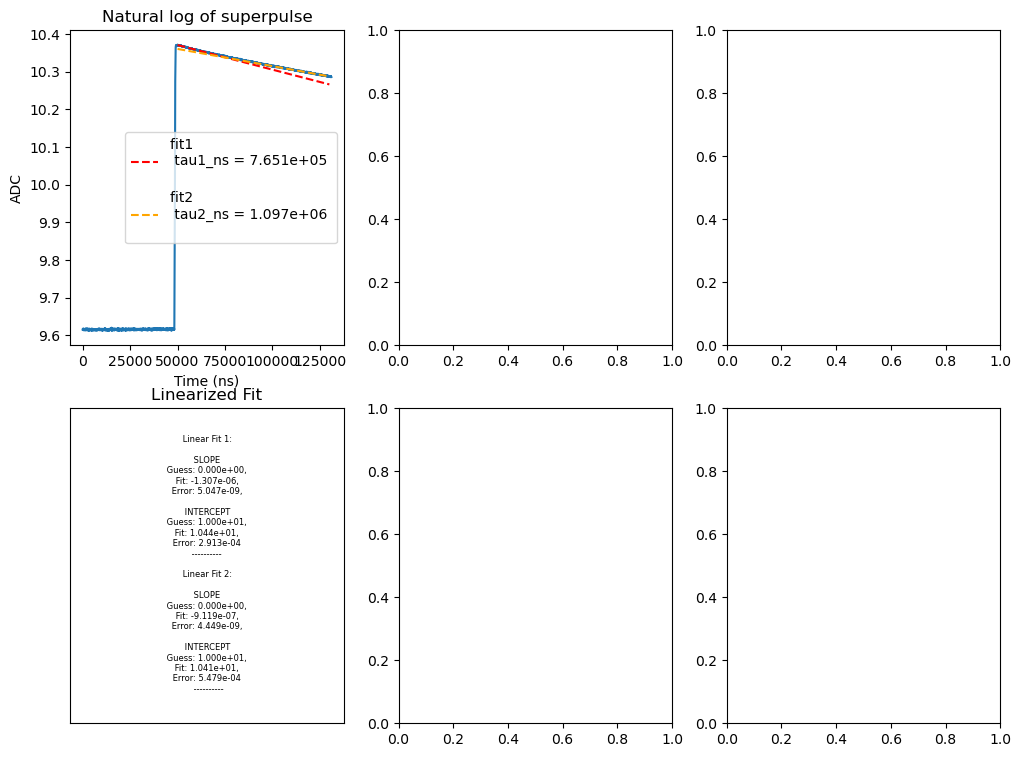

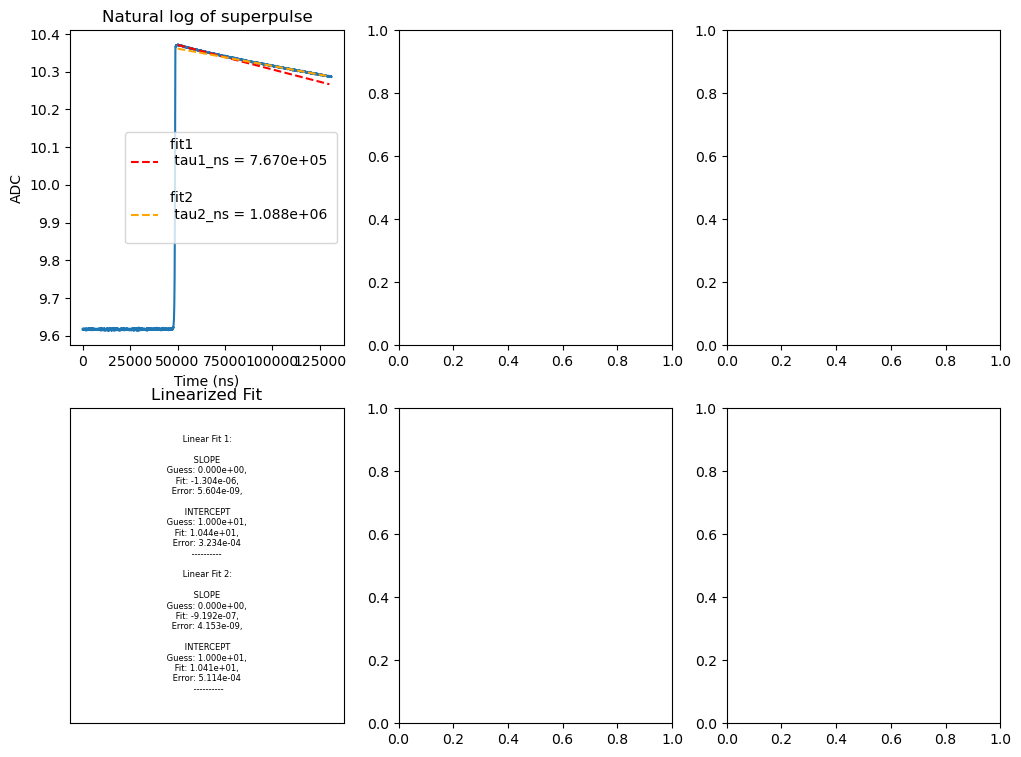

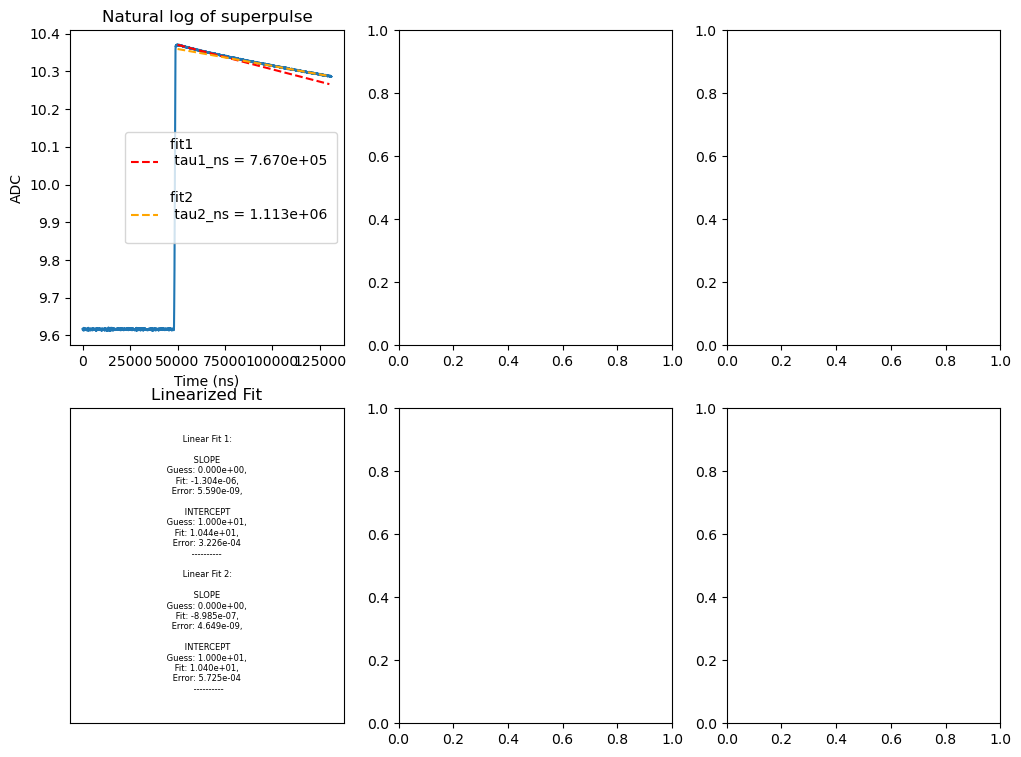

In [10]:
i = 0 # Choosing one file

# channel list
ch_list=lh5.ls(raw_file[i])

# extracting the datetime stamp
try:
    dt = raw_file[i][raw_file[i].index("-cal-") + len("-cal-"):raw_file[i].index("-tier_raw.lh5")]
except:
    dt = raw_file[i][raw_file[i].index("-phy-") + len("-phy-"):raw_file[i].index("-tier_raw.lh5")]

# Making a dictionary of germanium detectors
lmeta = LegendMetadata()
chmap = lmeta.hardware.configuration.channelmaps.on(dt)
channel_dict = {}
for channel_name, channel_data in chmap.items():
    if (channel_data.system == "geds"):
        channel_dict[channel_data["daq"]["rawid"]] = (channel_name, channel_data.location.string, channel_data.location.position)

# Choosing one channel
ch = 1104000

pdf_pages = PdfPages(f"{channel_dict[ch][0]}_pulses.pdf")
    
# Pull the hit dataframe
hit_df = lh5.load_dfs(hit_file[i], ["cuspEmax_ctc_cal","timestamp"], f"ch{ch}/hit")

# Get an energy selection
energy_selection1 = energy_selection(hit_df, 2611, 2617)

# Pull out event numbers
energy_selection1_index = hit_df["cuspEmax_ctc_cal"][energy_selection1].index

# Pull out the corresponding waveforms
store = LH5Store()
data_raw, n_tot = store.read_object(f"ch{ch}/raw/waveform", raw_file[i], n_rows=np.inf)

# Get the number of events
#evts = hit_df["cuspEmax_ctc_cal"].index

#Create an empty dataframe
df = pd.DataFrame(columns = ['timestamp', 'evt', 'energy', 'tau1_ns', 'tau1_err', 'tau2_ns', 'tau2_err'])

for evt in energy_selection1_index:
    print(evt)
    # Setting up the multiplot
    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 9))

    # Reject the pileup
    pileup = pileup_flagger(data_raw, evt)
    if pileup == False:
        try:
            # Generating the natural log of the pulse to get estimates
            lwf_yval = []
            for x in data_raw.values[evt]:
                lwf_yval.append(math.log(x))

            # Generating the timestamps, considering that one tick is 16 us
            wf_xval = np.arange(16*len(data_raw.values[evt]), step = 16)

            # data for the linear fit in the fast tau region
            xval_t1 = wf_xval[3200:4000]
            yval_t1 = lwf_yval[3200:4000]

            # data for the linear fit in the slow tau region
            xval_t2 = wf_xval[-1000:]
            yval_t2 = lwf_yval[-1000:]

            # linear fit for the fast tau region
            initialguess = [0, 10]
            fit_t1, covariance_t1 = optimize.curve_fit(           
                     linear,                                     
                     xval_t1,   
                     yval_t1,    
                     initialguess)  
            fit_t1_err = np.sqrt(np.diag(covariance_t1)) # From scipy documentation

            # linear fit for the slow region
            fit_t2, covariance_t2 = optimize.curve_fit(           
                     linear,                                     
                     xval_t2,   
                     yval_t2,    
                     initialguess)  
            fit_t2_err = np.sqrt(np.diag(covariance_t2)) # From scipy documentation

            # Generate the fitted lines for plotting
            x_fit_t1 = np.linspace(50000,130000, 100)
            y_fit_t1 = linear(x_fit_t1, *fit_t1)

            x_fit_t2 = np.linspace(50000,130000, 100)
            y_fit_t2 = linear(x_fit_t2, *fit_t2)

            # Plot the linearized function and fits
            axs[0,0].plot(wf_xval,lwf_yval)
            axs[0,0].plot(x_fit_t1, y_fit_t1, c = "red", linestyle = "dashed", label = f"fit1 \n tau1_ns = {-1/fit_t1[0]:.3e} \n")
            axs[0,0].plot(x_fit_t2, y_fit_t2, c = "orange", linestyle = "dashed", label = f"fit2 \n tau2_ns = {-1/fit_t2[0]:.3e} \n")
            axs[0,0].set_title(f"Natural log of superpulse")
            axs[0,0].set_xlabel("Time (ns)")
            axs[0,0].set_ylabel("ADC")
            axs[0,0].legend()

            # Set text only
            axs[1,0].set_xticks([])
            axs[1,0].set_yticks([])
            axs[1,0].set_title("Linearized Fit")
            axs[1,0].text(0.5, 0.1, f" Linear Fit 1: \n \n SLOPE \n Guess: {initialguess[0]:.3e}, \n Fit: {fit_t1[0]:.3e}, \n Error: {fit_t1_err[0]:.3e}, \n \n INTERCEPT \n Guess: {initialguess[1]:.3e}, \n Fit: {fit_t1[1]:.3e}, \n Error: {fit_t1_err[1]:.3e} \n ---------- \n \n Linear Fit 2: \n \n SLOPE \n Guess: {initialguess[0]:.3e}, \n Fit: {fit_t2[0]:.3e}, \n Error: {fit_t2_err[0]:.3e}, \n \n INTERCEPT \n Guess: {initialguess[1]:.3e}, \n Fit: {fit_t2[1]:.3e}, \n Error: {fit_t2_err[1]:.3e} \n ----------", fontsize=6, ha='center')

            # Amplitude and baseline estimators
            amp = amp_est(data_raw.values[evt])
            bsln = bsln_est(data_raw.values[evt])

            # Fitting superpulse to the double exponential
            initialguess = [bsln, abs(amp/2), abs(amp), abs(-1/fit_t1[0]), abs(-1/fit_t2[0])]
            bounds = ([bsln-0.1, 0, 0, 0, 0], [bsln+0.1, amp, np.inf, np.inf, np.inf]) # force all parameters positive
            expfit, expfit_covariance = optimize.curve_fit(           
                    doubleExp,                                     
                    wf_xval[3200:],   
                    data_raw.values[evt][3200:],    
                    initialguess,
                    bounds = bounds)  

            expfit_err = np.sqrt(np.diag(expfit_covariance)) # From scipy documentation

            # Generate a fitted double exp line for plotting
            expfit_y = doubleExp(wf_xval[3200:], *expfit)

            # Plot the superpulse and the doubleExp fitted line
            axs[0,1].plot(wf_xval, data_raw.values[evt], c = "cyan" , label = "data \n")
            axs[0,1].plot(wf_xval[3200:], expfit_y, c = "red", linestyle = 'solid', label = f"fit \n tau1_ns = {expfit[3]:.3e} \n tau2_ns = {expfit[4]:.3e} \n")
            axs[0,1].set_title(f"doubleExp fits")
            axs[0,1].set_xlabel("Time (ns)")
            axs[0,1].set_ylabel("ADC")
            axs[0,1].legend()

            # Set text only
            axs[1,1].set_xticks([])
            axs[1,1].set_yticks([])
            axs[1,1].set_title("Double Exponential Fit")
            axs[1,1].text(0.5, 0.05, f" Expfit: \n \n BASELINE \n Guess: {initialguess[0]:.3e}, \n Fit: {expfit[0]:.3e}, \n Error: {expfit_err[0]:.3e}, \n \n AMPLITUDE1 \n Guess: {initialguess[1]:.3e}, \n Fit: {expfit[1]:.3e}, \n Error: {expfit_err[1]:.3e}, \n \n AMPLITUDE \n Guess: {initialguess[2]:.3e}, \n Fit: {expfit[2]:.3e}, \n Error: {expfit_err[2]:.3e}, \n \n TAU1 \n Guess: {initialguess[3]:.3e}, \n Fit: {expfit[3]:.3e}, \n Error: {expfit_err[3]:.3e}, \n \n TAU2 \n Guess: {initialguess[4]:.3e}, \n Fit: {expfit[4]:.3e}, \n Error: {expfit_err[4]:.3e} \n ----------", fontsize=6, ha='center')

            # Set text only
            axs[1,2].set_xticks([])
            axs[1,2].set_yticks([])
            axs[1,2].set_title("Info")
            energy = hit_df["cuspEmax_ctc_cal"][evt]
            axs[1,2].text(0.5, 0.3, f" Detector: {channel_dict[ch][0]}, \n E:{energy:.2f} keV, \n event:{evt} \n ----------", fontsize=12, ha='center')

            # Plot the residuals
            axs[0,2].plot(data_raw.values[evt][3200:], data_raw.values[evt][3200:]-expfit_y, c="red")

            # Add to the dataframe
            #df = df.append({'timestamp' : hit_df["timestamp"][evt] , 'evt' : evt, 'energy': energy, 'tau1_ns' : expfit[3], 'tau1_err': expfit_err[3], 'tau2_ns': expfit[4], 'tau2_err': expfit_err[4]}, ignore_index = True)
            df.loc[evt] = {'timestamp' : hit_df["timestamp"][evt] , 'evt' : evt, 'energy': energy, 'tau1_ns' : expfit[3], 'tau1_err': expfit_err[3], 'tau2_ns': expfit[4], 'tau2_err': expfit_err[4]}

            # Format the figure globally and save
            fig.tight_layout()
            #fig.show()
            pdf_pages.savefig(fig)
            plt.close(fig)
        except:
            continue
pdf_pages.close()

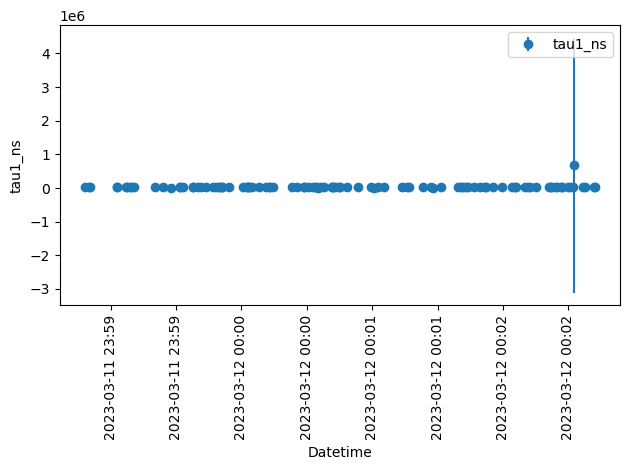

In [61]:
import matplotlib.dates as md
import datetime
import time

# Convert Unix timestamp to datetime
df['datetime'] = [datetime.datetime.utcfromtimestamp(ts) for ts in df['timestamp']]

# Create the error bar plot
fig, ax = plt.subplots()
ax.errorbar(df['datetime'], df['tau1_ns'], yerr=df['tau1_err'], fmt='o', label='tau1_ns')
ax.set_yscale('linear')
#ax.set_ylim(1e4, 4e4)

# Format the x-axis as datetime
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d %H:%M'))

# Add labels and a legend
ax.set_xlabel('Datetime')
ax.set_ylabel('tau1_ns')
ax.legend()
plt.xticks(rotation = 90)

# Rotate x-axis labels for better readability (optional)
plt.tight_layout()
plt.show()

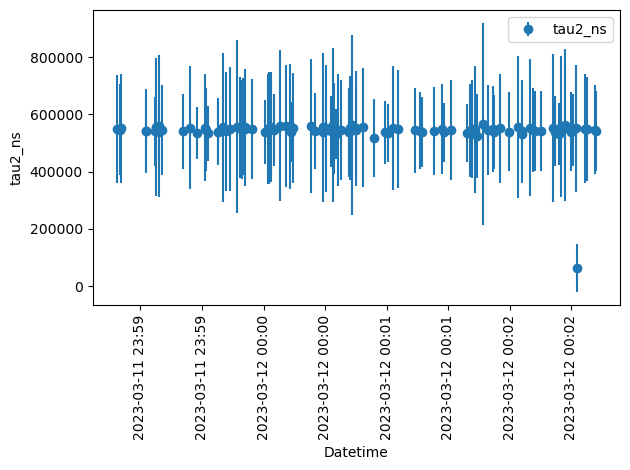

In [60]:
# Convert Unix timestamp to datetime
df['datetime'] = [datetime.datetime.utcfromtimestamp(ts) for ts in df['timestamp']]

# Create the error bar plot
fig, ax = plt.subplots()
ax.errorbar(df['datetime'], df['tau2_ns'], yerr=df['tau2_err'], fmt='o', label='tau2_ns')
ax.set_yscale('linear')
#ax.set_ylim(1e3, 1e6)

# Format the x-axis as datetime
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d %H:%M'))

# Add labels and a legend
ax.set_xlabel('Datetime')
ax.set_ylabel('tau2_ns')
ax.legend()
plt.xticks(rotation = 90)

# Rotate x-axis labels for better readability (optional)
plt.tight_layout()
plt.show()